In [16]:
# Imports
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
from textblob import TextBlob
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import load_stock_data,load_news_data
from correlation import calculate_sentiment, aggregate_daily_sentiment, calculate_daily_returns, merge_sentiment_returns,compute_correlation,plot_sentiment_vs_returns,rolling_correlation_analysis,lagged_sentiment_analysis

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
# Step 2: Load the datasets
news_file = '../data/raw_analyst_ratings.csv'  # Replace with your path

# Define the stock files and corresponding tickers
stock_files = {
    'AAPL': '../data/AAPL_historical_data.csv',
    'AMZN': '../data/AMZN_historical_data.csv',
    'GOOG': '../data/GOOG_historical_data.csv',
    'META': '../data/META_historical_data.csv',
    'MSFT': '../data/MSFT_historical_data.csv',
    'NVDA': '../data/NVDA_historical_data.csv',
    'TSLA': '../data/TSLA_historical_data.csv'
}

In [3]:
print("Loading News Data...")
news_df = load_stock_data(news_file)
print(f"News Data Loaded: {news_df.shape[0]} rows")

Loading News Data...
News Data Loaded: 1407328 rows


In [5]:
print("Loading Stock Data...")
stock_dfs = []
for stock, path in stock_files.items():
    df = load_stock_data(path)
    df['stock'] = stock
    stock_dfs.append(df)
stock_df = pd.concat(stock_dfs, ignore_index=True)
print(f"Stock Data Loaded: {stock_df.shape[0]} rows, {stock_df['stock'].nunique()} stocks")

Loading Stock Data...
Stock Data Loaded: 45428 rows, 7 stocks


In [6]:
# Step 3: Calculate sentiment scores
news_df = calculate_sentiment(news_df)

In [7]:
# Step 4: Aggregate daily sentiment per stock if applicable
# Assuming news_df has a 'stock' column, otherwise just daily sentiment for all
if 'stock' in news_df.columns:
    daily_sentiment = aggregate_daily_sentiment(news_df, by_stock=True)
else:
    daily_sentiment = aggregate_daily_sentiment(news_df)

print(f"Aggregated Daily Sentiment: {daily_sentiment.shape[0]} rows")


Aggregated Daily Sentiment: 44204 rows


In [8]:
# Step 5: Calculate daily returns for each stock
stock_df = calculate_daily_returns(stock_df)

In [9]:
# Step 6: Merge sentiment and stock returns
merged_df = merge_sentiment_returns(daily_sentiment, stock_df)
print(f"Merged DataFrame: {merged_df.shape[0]} rows")

Merged DataFrame: 14 rows


In [10]:

# Step 7: Compute and display overall correlation
corr, p_val = compute_correlation(merged_df)
print(f"Overall Pearson correlation: {corr:.4f} (p-value: {p_val:.4g})")

Overall Pearson correlation: -0.0033 (p-value: 0.9911)


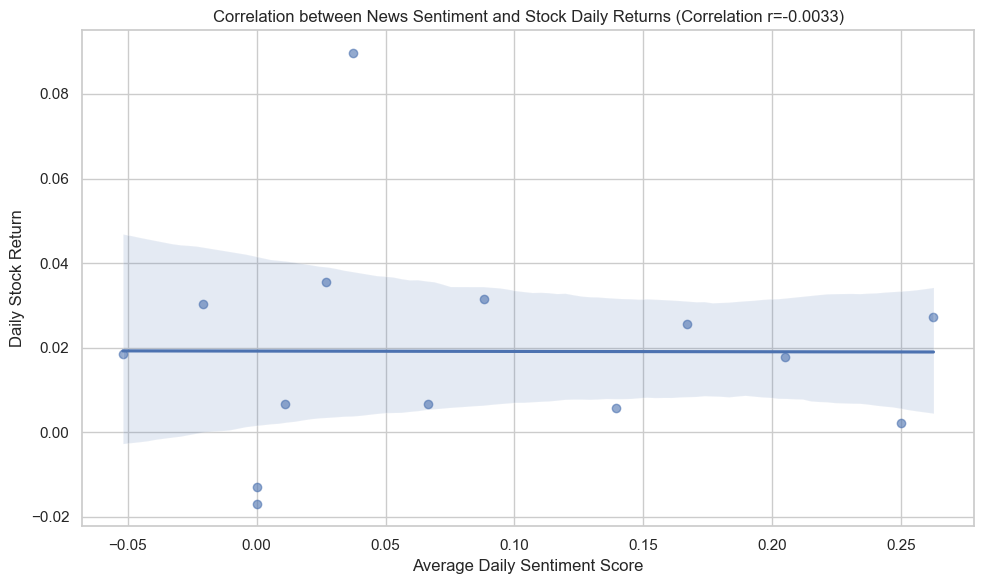

In [11]:
# Step 8: Plot sentiment vs daily return scatter + regression line
plot_sentiment_vs_returns(merged_df, title_suffix=f"(Correlation r={corr:.4f})")

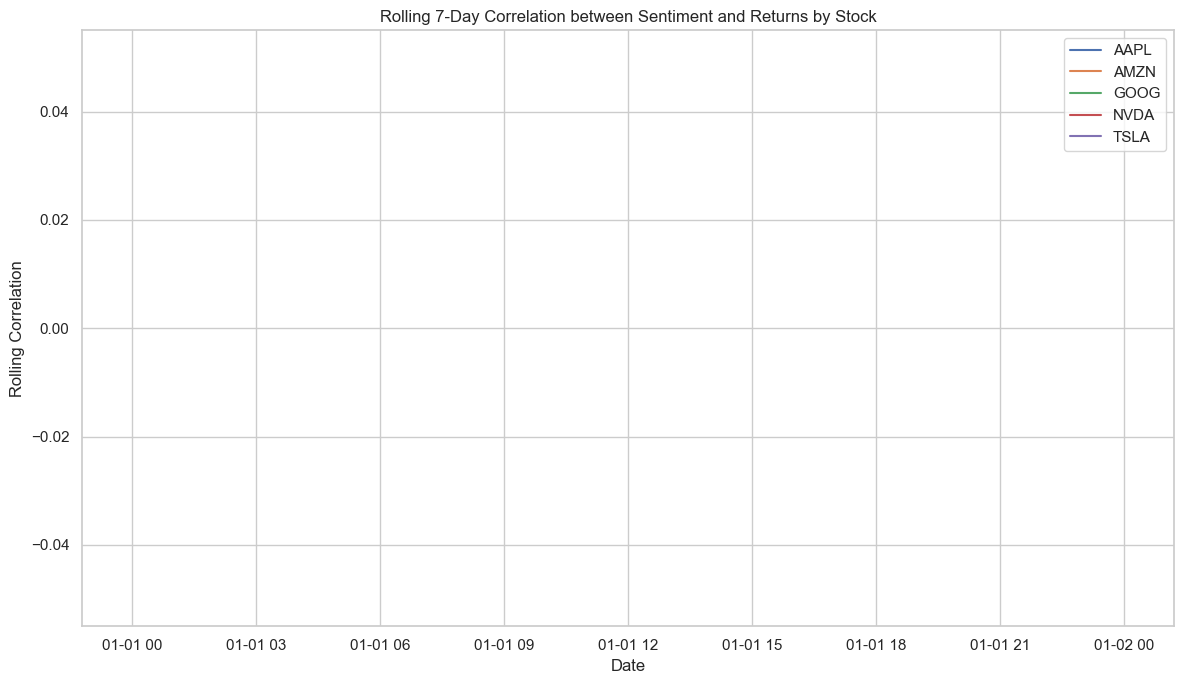

In [12]:
# Step 9: Rolling correlation analysis (e.g. 7-day window)
rolling_correlation_analysis(merged_df, window=7)

In [17]:
# Step 10: Lagged sentiment correlation analysis (up to 5-day lag)
lagged_corr_df = lagged_sentiment_analysis(merged_df, max_lag=5)
print("Lagged Sentiment Correlation Results:")
display(lagged_corr_df)

Lagged Sentiment Correlation Results:


,stock,lag,correlation,p_value
0,GOOG,1,-0.248683,0.751317
1,NVDA,1,-0.318936,0.793349
2,GOOG,2,0.303615,0.803613


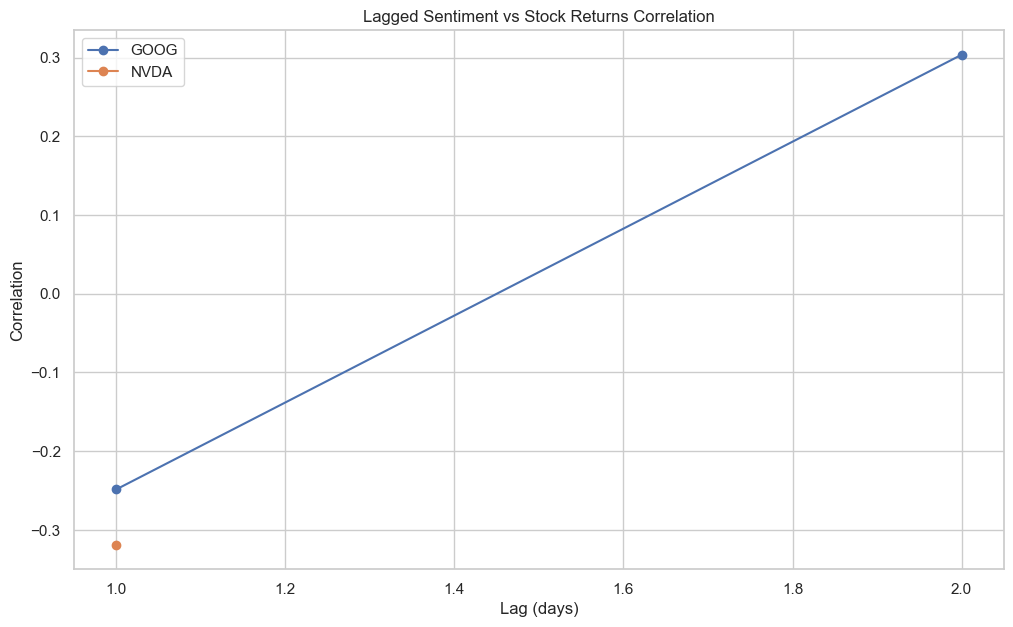

In [18]:
# Optional: Plot lagged correlation per stock
import matplotlib.pyplot as plt
if 'stock' in lagged_corr_df.columns and lagged_corr_df['stock'].notnull().any():
    for stock in lagged_corr_df['stock'].unique():
        sub = lagged_corr_df[lagged_corr_df['stock'] == stock]
        plt.plot(sub['lag'], sub['correlation'], marker='o', label=stock)
else:
    plt.plot(lagged_corr_df['lag'], lagged_corr_df['correlation'], marker='o', label='All Stocks')

plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.title("Lagged Sentiment vs Stock Returns Correlation")
plt.legend()
plt.grid(True)
plt.show()